## Imports

In [1]:
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

from models.sphericaldeconvolution.spherical_deconvolution import spherical_deconvolution_fit
from models.sphericaldeconvolution.fibre_response_function import simple_fibre_response_function, diffusion_tensor_response_function
from dataloader.load_dt_simulated import load_dt_simulated_multiple_populations
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion

## Load data

In [2]:
bvals, qhat, dwis = load_dt_simulated_multiple_populations(number_of_data_points=90, 
                                                           b_value=1000,
                                                           b_0_signal=3000,
                                                           include_b_0=False,
                                                           signal_to_noise_ratio=0.1,
                                                           eigenvalues=[(0.003, 0.0002, 0.0002),(0.0002, 0.003, 0.0002)],
                                                           eigenvectors=[None,None],
                                                           fractions=[0.5,0.5],
                                                           noise_type='rician',
                                                           noise_generator_seed=1,
                                                           gradient_generator_seed=1)

## Pre-processing

In [3]:
bvals, qhat, dwis = extend_dataset_with_origin_reflections(bvals, qhat, dwis)

thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)

voxel = dwis

# Spherical deconvolution

Even though the diffusion tensor model was among the first widely adopted models, it has major limitations, i.e. it is unable to resolve complex fibre configurations such as fibre crossings or (in a tractography context) track fibres through regions of crossing fibres. The diffusion tensor only shows the overall diffusion in a voxel. The issue of crossing fibres was first disregarded since it was believed that only a few problematic regions (like centrum semiovale and pons) were affected. However, further studies have shown that fibre crossings are of common occurrence in the human brain. According to the estimates, 70-90% of white matter contains fibre crossings of at least two fibre populations$^{[1,2,3,4]}$. Therefore spherical deconvolution (SD) was adopted to model multiple fibre orientations in a voxel. 

The main assumption of SD is that the diffusion properties of white matter fibres are the same across all brain regions (this behaviour is modelled by the "fibre response function" see below), and thus the changes in detected signal are only caused by partial volume effects.

## Mixture models

Mixture models estimate the orientation of fibres and their volume fractions by modelling the signal that would be captured for a single population of fibres. The actual signal coming from a voxel is thus assumed to be composed of signals that would have been measured for each population (compartment) in isolation. Water exachge between compartments is not assumed to be negligible. The diffusion due to cerebrospinal fluid (CSF) can be modelled by an isotropic compartment.

## Fibre response function

Fibre response function (FRF) models the signal coming from a single fibre population. It can be estimated from the diffusion tensor model by fitting the DT model in a region that is known to have high anisotropy (like corpus callosum) and thus the voxel is likely to contain only one dominant fibre orientation.

FRF is axially symmetric (only depends on collatitude $\theta$) i.e. $R(\theta)=R(\theta,\phi)$.

## Spherical deconvolution

As mentioned above the core concept behind spherical deconvolution is that the voxel signal can be expressed as a weighted sum of one or more fibre populations. These populations are assumed to be identical in terms of their signal response i.e. the signal is attenuated along the fibres and preserved across the fibres. Thus the resulting voxel signal depends only the orientation of the fibres and the fraction of volume they occupy in the voxel. Equivalently the signal can also be expressed as a convolution over the sphere of an fODF with an FRF. See figure below:

![DODF_VS_FODF](./figures/sd_approach.png)

In order to infer fODF the problem is inverted and fODF is estimated from the measured signal given the FRF. The advantage of SD is that the number of fibre populations does not need to be estimated in advance as opposed to other approaches like multiple diffusion tensor model $^{[6]}$.

More formally, SD is a mixture model for estimation of the continuous fibre orientation distribution function (fODF) where the fODF is parametrized by the SH coefficients. And the signal can be written as (Eq 1):

$$S(\theta, \phi)=\sum_{i}^{N}f_{i}\hat{A}_iR(\theta)$$

where $f_{i}$ is the volume fraction of the *i*-th fibre population, $\hat{A}_{i}$ is the operator that rotates the axially symmetric FRF $R(\theta)$ in the direction of the *i*-th fibre population i.e. $(\theta_{i}, \phi_{i})$ and $N$ is the number of distinct fibre populations. Equivalently the signal can be written as a convolution over a unit sphere of the FRF with the fODF $F$ (Eq 2):

$$S(\theta, \phi)=F \ast  R (\theta,\phi) \equiv S(\mathbf{\hat{q}})=\int_{S^{2}}^{}F(\mathbf{\hat{x}})R(\mathbf{\hat{q}};\mathbf{\hat{x}})d\mathbf{\hat{x}}$$

Where $\mathbf{\hat{q}}$ is the gradient orientation in Cartesian coordinates instead of spherical coordinates $(\theta,\phi)$, $\mathbf{\hat{x}}$ denotes orientation of the fibre population in Cartesian coordinates and $R(\mathbf{\hat{q}};\mathbf{\hat{x}})$ is the FRF aligned (rotated) with the direction of $\mathbf{\hat{x}}$ measured under gradient $\mathbf{\hat{q}}$.

The fODF represents a fraction of fibres going in a direction $(\theta, \phi)$. Now let a voxel contain $N$ distinct fibre populations with different orientations then fODF can be defined as a weighted sum of $N$ Dirac delta functions pointing in the way of the fibre populations where the weights are the volume fractions of the fibre populations:

$$F(\theta, \phi) = \sum_{i}^{N}f_{i}\delta_{\theta_{i},\phi_{i}}(\theta,\phi)$$

where $\delta_{\theta_{i},\phi_{i}}(\theta,\phi)$ is the Dirac delta function in spherical coordinates centered at the direction of the *i*-th fibre population and is therefore defined as:

$$\delta_{\theta_{i},\phi_{i}}(\theta,\phi)=\delta(\mathbf{r}-\mathbf{r_0})=\frac{1}{sin\theta}\delta(\theta - \theta_{0})\delta(\phi - \phi_{0})$$

where $\mathbf{r}$ is the vector of spherical coordinates $(\theta,\phi)$ and $\mathbf{r_{0}}$ is the vector of spherical coordinates $(\theta_{0},\phi_{0})$ where the Dirac delta function is centered.

If FRF $R(\theta)$ is known then the fODF can be computed by deconvolving $R(\theta)$ from the signal $S(\theta, \phi)$.

In [4]:
fibre_response_function_partial = partial(diffusion_tensor_response_function,
                                          b_value=1000,
                                          diffusion_tensor_eigenvalues=(0.003, 0.0002, 0.0002),
                                          b_0_signal=3000)

In [5]:
fODF_coefficients = spherical_deconvolution_fit(fibre_response_function=fibre_response_function_partial,
                                                measurements=voxel,
                                                qhat=qhat,
                                                b_value=1000,
                                                max_degree=8,
                                                number_of_samples_of_fibre_response_function=200)

In [6]:
fODF_coefficients

array([ 2.81765488e-01, -4.69415141e-04, -5.17651161e-03, -3.14816470e-01,
       -1.62432075e-03, -1.84358577e-03, -7.16320974e-03, -1.17939895e-03,
       -1.00071306e-02,  4.17145943e-03,  3.13021356e-01,  9.14971462e-03,
        5.61096766e-03, -1.14172217e-02,  6.23319712e-01, -4.27962834e-03,
        7.12367232e-02, -4.18040161e-03, -2.26574768e-03,  6.43408465e-02,
        2.17619795e-02, -3.38439803e-01,  4.52449708e-02, -6.35048179e-02,
        4.78273445e-02, -5.33393101e-01, -8.29100041e-03, -6.11339789e-03,
        2.49618743e-02,  1.60074221e-01,  9.81970911e-02, -1.25055320e-01,
        3.13546323e-01, -1.13909743e-01,  1.07090369e-01, -1.08735611e-01,
        5.42219748e-01,  2.88947725e-02,  5.99088144e-02, -6.92617552e-02,
        7.58193223e-01,  6.96396438e-01,  2.07664298e-02,  5.25145034e-01,
        1.04699026e+00])

## Plot predicted fODF

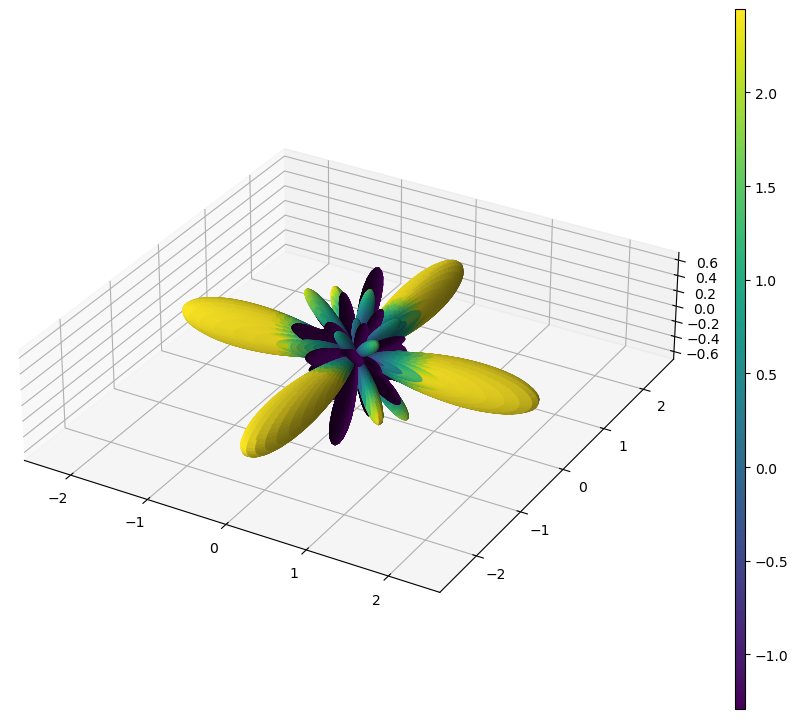

In [7]:
#%matplotlib qt

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(fODF_coefficients,max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(fcolors), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

## Distribution of fODF values

(array([  224.,  1986., 10056., 13126., 10702.,  2251.,   578.,   424.,
          379.,   274.]),
 array([-1.29132642, -0.91762699, -0.54392757, -0.17022815,  0.20347127,
         0.57717069,  0.95087012,  1.32456954,  1.69826896,  2.07196838,
         2.4456678 ]),
 <BarContainer object of 10 artists>)

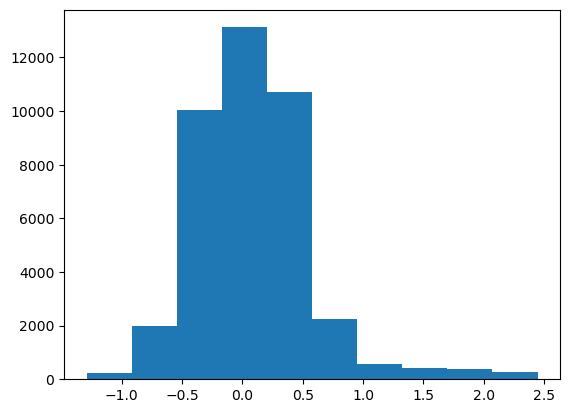

In [8]:
plt.hist(fcolors.flatten())

## Model evaluation

In [9]:
qhat = np.load('./data/dt_simulated_2_populations/gradient_orientations.npy')
measurements = np.load('./data/dt_simulated_2_populations/diffusion_weighted_signals.npy')
fODFs = np.load('./data/dt_simulated_2_populations/fODF_sh_coefficients.npy')

qhat.shape

(1000, 3, 90)

In [10]:
qhat.shape

(1000, 3, 90)

In [11]:
fibre_response_function_partial = partial(diffusion_tensor_response_function,
                                          b_value=1000,
                                          diffusion_tensor_eigenvalues=(0.003, 0.0002, 0.0002),
                                          b_0_signal=3000)

In [12]:
fODF_coefficients = spherical_deconvolution_fit(fibre_response_function=fibre_response_function_partial,
                                                measurements=measurements[1],
                                                qhat=qhat[1],
                                                b_value=1000,
                                                max_degree=8,
                                                number_of_samples_of_fibre_response_function=200)

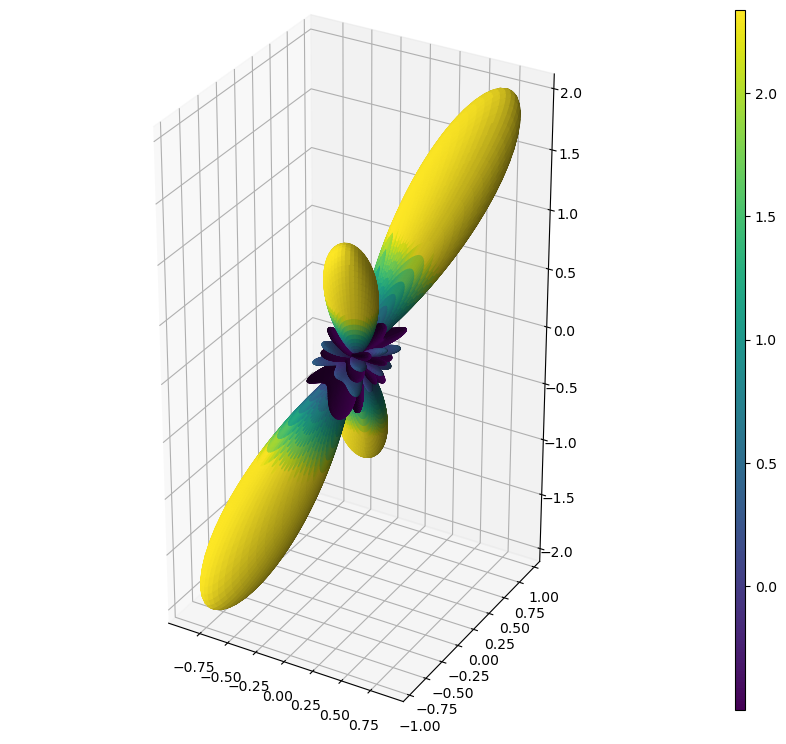

In [13]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(fODF_coefficients,max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(fcolors), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

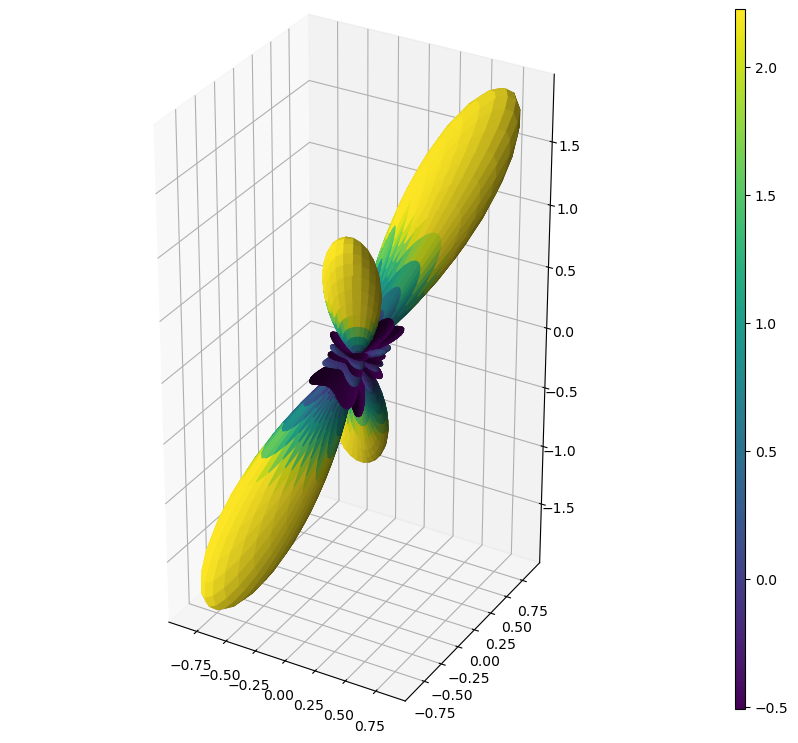

In [14]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(expansion_coefficients=fODFs[1], max_degree=8, resolution=100, min_value=None, max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(fcolors), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

In [15]:
fODFs[1]-fODF_coefficients

array([-1.14857795e-04,  3.81776707e-04, -1.18106680e-03,  6.89221809e-04,
       -3.83304312e-04,  4.96446296e-04, -3.33166686e-04, -6.35237292e-04,
       -2.64334713e-03,  2.00261888e-03,  1.69108411e-03,  1.61898260e-03,
       -1.79558069e-03, -4.33651211e-03,  5.49276013e-04, -1.92027433e-03,
        2.17403602e-03,  3.47713724e-03,  7.04113150e-04,  1.40001968e-02,
        1.38226562e-02, -2.04833322e-02,  1.14347413e-03, -1.46488387e-02,
        2.42720819e-02, -4.33825843e-03,  1.01696285e-03,  7.10543575e-05,
        1.93255103e-02, -3.09861927e-02,  5.56813363e-02, -1.31173183e-01,
        4.31970137e-02,  5.81180436e-02, -1.40680764e-02, -4.52409172e-02,
        1.09229235e-02, -3.09096269e-02,  3.26908816e-02, -4.86771679e-02,
        2.12495653e-02,  8.11195586e-03, -5.60846753e-02, -1.98580417e-02,
        1.59061710e-02])

In [16]:
fODF_coefficients

array([ 0.28220965,  0.02687792, -0.02028633,  0.38129903, -0.2820549 ,
       -0.04297802,  0.01797848, -0.08578846,  0.11680144, -0.06426524,
       -0.01049447, -0.3793853 , -0.14602495,  0.18212403, -0.0291815 ,
       -0.00609736,  0.00147851,  0.09283509, -0.23525865,  0.18391306,
       -0.10084235, -0.37095712, -0.13588536, -0.16659566,  0.44344017,
       -0.16169008, -0.00504614,  0.00726212, -0.02015074,  0.04978985,
       -0.11907512,  0.15367529,  0.15978588, -0.3804444 ,  0.20041958,
        0.00772853, -0.36517542,  0.26333536, -0.09927689,  0.65545736,
       -0.40886522, -0.01652679,  0.11192889,  0.00878766, -0.01603927])

## References

1 Behrens TEJ, Berg HJ, Jbabdi S, Rushworth MFS, Woolrich MW. Probabilistic diffusion tractography with multiple fibre orientations: what can we gain? Neuroimage. 2007;34:144‐155

2 Jeurissen B, Leemans A, Tournier J‐D, Jones DK, Sijbers J. Investigating the prevalence of complex fiber configurations in white matter tissue with diffusion magnetic resonance imaging. Hum Brain Mapp. 2013;34:2747‐2766

3 Dell'Acqua F, Simmons A, Williams SCR, Catani M. Can spherical deconvolution provide more information than fiber orientations? Hindrance modulated orientational anisotropy, a true‐tract specific index to characterize white matter diffusion. Hum Brain Mapp. 2013;34:2464‐2483

4 Descoteaux M, Deriche R, Knösche TR, Anwander A. Deterministic and probabilistic tractography based on complex fibre orientation distributions.
IEEE Trans Med Imaging. 2009;28:269‐286

5 Jones DK, Knösche TR, Turner R. White matter integrity, fiber count, and other fallacies: the do's and don'ts of diffusion MRI. Neuroimage. 2013;73:239‐254.

6 Tuch, D.S., Reese, T.G., Wiegell, M.R., Makris, N., Belliveau, J.W., Wedeen, V.J., 2002. High angular resolution diffusion imaging reveals intravoxel white matter fiber heterogeneity. Magn. Reson. Med. 48, 577 – 582.